# Testing and comparing different scipy.optimize.curve_fit() methods
## Methods: 'lm' (default), 'trf', 'dogbox'

I will be using the "piecing method" to find best fit parameters, as described in 'piecing_method_for_best_fit.ipynb'.

In [1]:
pip install camb

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__, os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /opt/conda/lib/python3.9/site-packages/camb


In [3]:
# Create fake observational data #

pars_test = camb.set_params(H0=67.5, 
                            ombh2=0.022, 
                            omch2=0.120*1.03, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_A_baryon = 0, 
                            HMCode_eta_baryon = 0, 
                            HMCode_logT_AGN = -10)
                            # zero the HMCode to get a universe without baryonic feedback
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

## method = 'lm'

In [20]:
# Find best fit params #

def baryon_model_mead(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([3.13, 0.603, 7.8])
popt_mead, pcov_mead = scipy.optimize.curve_fit(baryon_model_mead, kh_data, pk_data, guesses) 



def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([3.13, 0.603, 7.8])
popt_feedback, pcov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, kh_data, pk_data, guesses)

In [22]:
best_fit_params_mead = popt_mead
best_fit_params_feedback = popt_feedback

pieced_together_best_fit_params_lm = np.array([best_fit_params_mead[0], best_fit_params_mead[1], best_fit_params_feedback[2]])

print('Best fit params:', pieced_together_best_fit_params_lm)

Best fit params: [3.08755532 0.59485738 7.68979458]


In [23]:
pk_lm = baryon_model_feedback(kh_data, *pieced_together_best_fit_params_lm)

## method = 'trf'

In [24]:
def baryon_model_mead(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

popt_mead, pcov_mead = scipy.optimize.curve_fit(baryon_model_mead, kh_data, pk_data, bounds=([3.13*0.95, 0.603*0.95, 7.8*0.95], [3.13*1.05, 0.603*1.05, 7.8*1.05])) 



def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

popt_feedback, pcov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, kh_data, pk_data, bounds=([3.13*0.95, 0.603*0.95, 7.8*0.95], [3.13*1.05, 0.603*1.05, 7.8*1.05]))

In [25]:
best_fit_params_mead = popt_mead
best_fit_params_feedback = popt_feedback

pieced_together_best_fit_params_trf = np.array([best_fit_params_mead[0], best_fit_params_mead[1], best_fit_params_feedback[2]])

print('Best fit params:', pieced_together_best_fit_params_trf)

Best fit params: [3.28649921 0.57285    7.56959403]


In [26]:
pk_trf = baryon_model_feedback(kh_data, *pieced_together_best_fit_params_trf)

## method = 'dogbox'

In [27]:
def baryon_model_mead(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

popt_mead, pcov_mead = scipy.optimize.curve_fit(baryon_model_mead, kh_data, pk_data, bounds=([3.13*0.95, 0.603*0.95, 7.8*0.95], [3.13*1.05, 0.603*1.05, 7.8*1.05]), method='dogbox') 



def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

popt_feedback, pcov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, kh_data, pk_data, bounds=([3.13*0.95, 0.603*0.95, 7.8*0.95], [3.13*1.05, 0.603*1.05, 7.8*1.05]), method='dogbox')

In [28]:
best_fit_params_mead = popt_mead
best_fit_params_feedback = popt_feedback

pieced_together_best_fit_params_dogbox = np.array([best_fit_params_mead[0], best_fit_params_mead[1], best_fit_params_feedback[2]])

print('Best fit params:', pieced_together_best_fit_params_dogbox)

Best fit params: [3.2865     0.57285    7.68979519]


In [29]:
pk_dogbox = baryon_model_feedback(kh_data, *pieced_together_best_fit_params_dogbox)

## Comparison of results:

<Figure size 432x288 with 0 Axes>

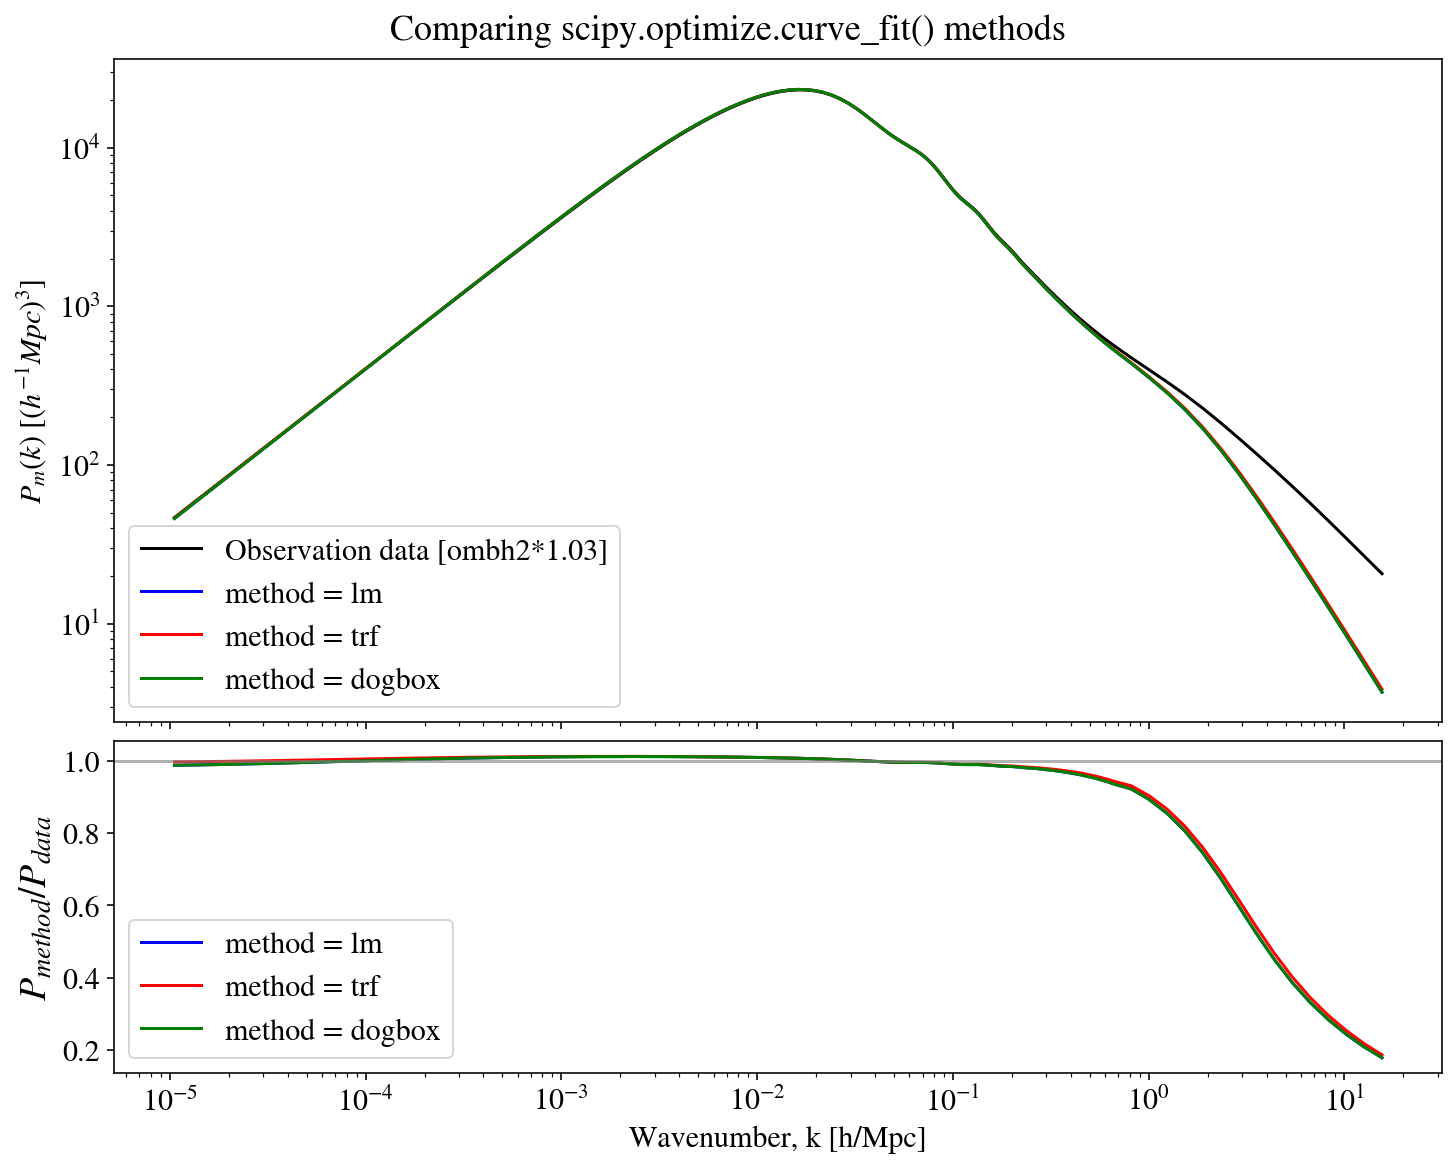

In [31]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(10,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})
fig.suptitle('Comparing scipy.optimize.curve_fit() methods')

ax0.loglog(kh_data, pk_data, 'k-', label='Observation data [ombh2*1.03]')
#ax0.loglog(kh_planck2018, pk_planck2018[0], 'g-', label='Planck2018 cosmology,\nno baryonic feedback')
ax0.loglog(kh_data, pk_lm, 'b-', label='method = lm')
ax0.loglog(kh_data, pk_trf, 'r-', label='method = trf')
ax0.loglog(kh_data, pk_dogbox, 'g-', label='method = dogbox')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(loc='best')
#props = dict(boxstyle='round', facecolor='white', alpha = 0.5)
#ax0.text(0.00001, 5000, 'Best fit parameters:\nA = {0:.3f}\neta = {1:.3f}\nlogT_AGN = {2:.3f}'.format(*pieced_together_best_fit_params), bbox=props)

ax1.semilogx(kh_data, pk_lm/pk_data, 'b-', label='method = lm')
ax1.semilogx(kh_data, pk_trf/pk_data, 'r-', label='method = trf')
ax1.semilogx(kh_data, pk_dogbox/pk_data, 'g-', label='method = dogbox')
ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{method}/P_{data}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.legend()
plt.show()